In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
sep = os.sep

In [7]:
m1_usa = pd.read_parquet('..' + sep + 'data' + sep + "M1NS" + sep +"M1NS.parquet")
m2_usa = pd.read_parquet('..' + sep + 'data' + sep + "M2NS" + sep +"M2NS.parquet")
cpi_usa = pd.read_parquet('..' + sep + 'data' + sep + 'CPIAUCNS' + sep +"CPIAUCNS.parquet")
pce_usa = pd.read_parquet('..' + sep + 'data' + sep + 'PCEPI' + sep +"PCEPI.parquet")

In [8]:
m1_usa

,M1NS
1959-01-01,142.2
1959-02-01,139.3
1959-03-01,138.4
1959-04-01,139.7
1959-05-01,138.7
...,...
2021-03-01,18740.1
2021-04-01,19066.4
2021-05-01,19144.1
2021-06-01,19292.6


In [4]:
m2_usa = m2_usa.pct_change(12).dropna()
m2_usa.rename(columns={'Value': 'M2'}, inplace=True)

In [5]:
cpi_usa = cpi_usa.pct_change(12).dropna()
cpi_usa.rename(columns={'Value': 'CPI'}, inplace=True)

In [6]:
ready_dataframe = pd.concat([m2_usa, cpi_usa], axis=1)

In [7]:
ready_dataframe.dropna(inplace=True)

In [8]:
ready_dataframe

,M2,CPI
1960-01-01,0.040373,0.010345
1960-02-01,0.037539,0.017301
1960-03-01,0.035776,0.017301
1960-04-01,0.034804,0.017241
1960-05-01,0.029979,0.017241
...,...,...
2021-02-01,0.270283,0.016762
2021-03-01,0.243645,0.026198
2021-04-01,0.183860,0.041597
2021-05-01,0.141617,0.049927


In [10]:
X = ready_dataframe[['M2']]
y = ready_dataframe['CPI']
print(type(y))
X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )

<class 'pandas.core.series.Series'>


In [10]:
lm = LinearRegression()

In [11]:
lm.fit(X_train, y_train)

LinearRegression()

In [12]:
print("Intercept:", lm.intercept_)
print("Coeficiente:", list(zip(X.columns, lm.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", lm.score(X, y))

Intercept: [0.03248365]
Coeficiente: [('M2', 0.05962635356623634)]
Coeficiente de determinación R^2: 0.005687374116321919


In [13]:
predicciones = lm.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[[0.03721317]
 [0.03567466]
 [0.03706452]]

El error (rmse) de test es: 0.028465729527558357


In [22]:
X_test[0:3,]

array([[1.        , 0.07931927],
       [1.        , 0.05351676],
       [1.        , 0.07682639]])

In [14]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.262
Date:                Wed, 25 Aug 2021   Prob (F-statistic):             0.0714
Time:                        12:32:07   Log-Likelihood:                 1271.5
No. Observations:                 590   AIC:                            -2539.
Df Residuals:                     588   BIC:                            -2530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0325      0.003     12.375      0.0

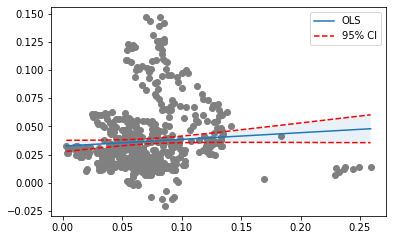

In [15]:
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train[:, 1]
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
ax.legend();

In [16]:
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 0.02846572952755836


C:\Users\serra\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


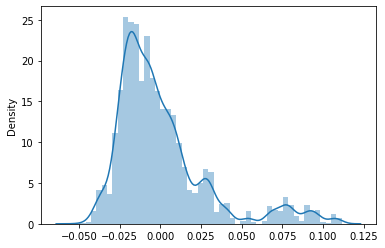

In [17]:
sns.distplot((y_test - predicciones));

In [18]:
print(lm.intercept_)

[0.03248365]


In [24]:
lm.predict([[1., 0.04]].reshape(-1, 1))

AttributeError: 'list' object has no attribute 'reshape'

C:\Users\serra\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


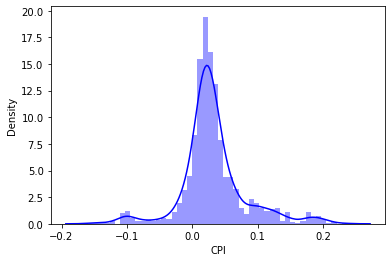

In [19]:
sns.distplot(cpi_usa['CPI'], color='Blue');